# Learned Cost Model Evaluation

In [1]:
from copy import deepcopy
import os
import random
import sys
from typing import Any, Optional, Tuple, Type

In [2]:
from matplotlib import cm
from matplotlib.ticker import PercentFormatter
from mpl_toolkits.mplot3d.axes3d import Axes3D
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import toml
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchinfo

pd.set_option('display.max_columns', 50)
pd.set_option('display.min_rows', 20)

In [3]:
sys.path.append(os.path.join(sys.path[0], '../../../'))

from endure.data.io import Reader
from endure.lcm.util import LCMEvalUtil
from endure.lcm.model.builder import LearnedCostModelBuilder
import endure.lcm.data.generator as Gen
from endure.ltune.data.generator import LTuneDataGenerator
from endure.lsm.types import Policy, LSMDesign, System, LSMBounds, STR_POLICY_DICT
from endure.lsm.cost import EndureCost

In [4]:
def save_fig(fig, filename):
    fig.savefig(os.path.join('/home/anwesha/transfer', filename), dpi=300, format='pdf', bbox_inches='tight')

In [5]:
model_path = '/data_comp/models/lcm/qcost/'
config = Reader.read_config(os.path.join(model_path, 'endure.toml'))
lsm_design = config['lsm']['design']

In [6]:
config['job']['LCMTrain']

{'max_epochs': 50,
 'save_dir': 'models/lcm/qcost',
 'no_checkpoint': False,
 'loss_fn': 'MSE',
 'optimizer': 'Adam',
 'lr_scheduler': 'Constant',
 'train': {'dir': 'train-data/lcm/std/qcost',
  'batch_size': 1024,
  'shuffle': True,
  'num_workers': 2,
  'drop_last': True},
 'test': {'dir': 'test-data/lcm/std/qcost',
  'batch_size': 4096,
  'shuffle': False,
  'num_workers': 4,
  'drop_last': True}}

In [7]:
bounds = LSMBounds() 

In [8]:
lsm_design

'QFixed'

In [9]:
if lsm_design in ['Level', 'Tier']:
    gen = Gen.ClassicGenerator(config)
elif lsm_design == 'KLSM':
    gen = Gen.KHybridGenerator(config)
elif lsm_design in ['QLSM', 'QLSMIntegerVars', 'QFixed']:
    gen = Gen.QCostGenerator(bounds)
else:
    gen = Gen.ClassicGenerator(config)

# Loss Graph

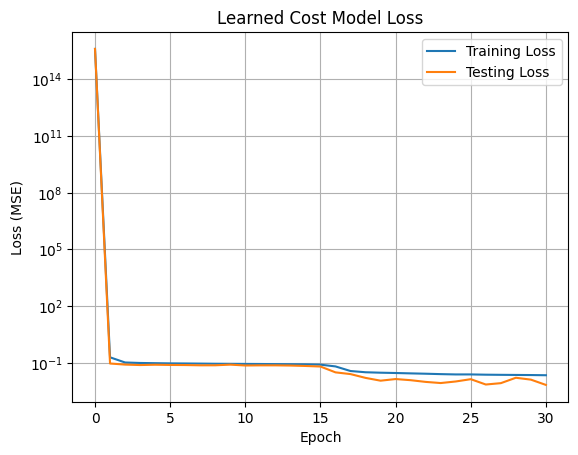

In [10]:
losses = pd.read_csv(os.path.join(model_path, 'losses.csv'))
losses = losses.loc[:30]
fig, ax = plt.subplots()
ax.plot(losses['epoch'], losses['train_loss'], label='Training Loss')
ax.plot(losses['epoch'], losses['test_loss'], label='Testing Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel(f'Loss ({config["job"]["LCMTrain"]["loss_fn"]})')
ax.set_yscale('log')
ax.grid()
ax.set_title(f'Learned Cost Model Loss')
_ = ax.legend()
# save_fig(fig, 'learned_cost_model_loss.pdf')

In [11]:
losses.idxmin()

epoch          0
train_loss    30
test_loss     30
dtype: int64

In [12]:
design_type = config['lsm']['design']
policy = STR_POLICY_DICT.get(design_type, Policy.Classic)

In [13]:
hidden_length: int = config["lcm"]["model"]["hidden_length"]
hidden_width: int = config["lcm"]["model"]["hidden_width"]
embedding_size: int = config["lcm"]["model"]["embedding_size"]
norm_layer: str = config["lcm"]["model"]["norm_layer"]
policy_embedding_size: int = config["lcm"]["model"]["policy_embedding_size"]
decision_dim: int = config["lcm"]["model"]["decision_dim"],
dropout: float = config["lcm"]["model"]["dropout"],
size_ratio_range: Tuple[int, int] = bounds.size_ratio_range
max_levels: int = bounds.max_considered_levels

In [17]:
print(decision_dim[0])

64


# Building

## Model

In [18]:
model_name = os.path.join(model_path, 'best.model')
# model_name = os.path.join(model_path, 'checkpoints/epoch_10.checkpoint')
# last_checkpoint = os.listdir(os.path.join(model_path, 'checkpoints'))[-1]
# model_name = os.path.join(model_path, 'checkpoints', last_checkpoint)
builder = LearnedCostModelBuilder(hidden_length, hidden_width, embedding_size, norm_layer, policy_embedding_size, decision_dim[0], dropout[0], size_ratio_range, max_levels)
model = builder.build_model(policy)
model_data = torch.load(model_name)
model_params = model_data['model_state_dict'] if model_name.endswith('checkpoint') else model_data
load_status = model.load_state_dict(model_params)
model.eval()
load_status

<All keys matched successfully>

In [19]:
model

QModel(
  (t_embedding): Linear(in_features=30, out_features=8, bias=True)
  (q_embedding): Linear(in_features=30, out_features=8, bias=True)
  (in_norm): BatchNorm1d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (in_layer): Linear(in_features=26, out_features=32, bias=True)
  (relu): ReLU(inplace=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU(inplace=True)
  )
  (out_layer): Linear(in_features=32, out_features=64, bias=True)
  (z0): Linear(in_features=16, out_features=1, bias=True)
  (z1): Linear(in_features=16, out_features=1, bias=True)
  (q): Linear(in_features=16, out_features=1, bias=True)
  (w): Linear(in_features=16, out_features=1, bias=True)
)

In [20]:
# torchinfo.summary(model, (1, 70), device='cpu')

# Utils

In [22]:
eval_util = LCMEvalUtil(bounds.size_ratio_range[0], bounds.size_ratio_range[1], bounds.max_considered_levels, model, gen)


In [23]:
wl = (z0, z1, q, w) = gen._sample_workload(4)
system = gen._sample_system()
design = gen._sample_design(system)
print(design)
print(system)
eval_util.cf.calc_cost(design, system, z0, z1, q, w), eval_util.eval_lcm(design, system, z0, z1, q, w)

LSMDesign(h=1.164, T=2, policy=<Policy.QFixed: 4>, Q=1, Y=1.0, Z=1.0, K=[])
System(E=1024, s=2.1559320735376016e-08, B=64.0, N=864113330, H=13.381676586369535, phi=1.0)


(2.256301733344635, 2.3286755084991455)

## LCM Evaluation

In [24]:
num_samples = 5000
table = []
bad = []
for _ in tqdm(range(num_samples)):
    row, design, system = eval_util.gen_random_sample()
    norm_delta = (row['cost_acm'] - row['cost_lcm']) / row['cost_acm']
    if (norm_delta < -1) or (norm_delta > 1):
        print(norm_delta, system, design, row['z0'], row['z1'], row['q'], row['w'])
        bad.append((norm_delta, row['z0'], row['z1'], row['q'], row['w'], design, system))
    table.append(deepcopy(row))
table = pd.DataFrame(table)
df = table

  0%|          | 0/5000 [00:00<?, ?it/s]

-1.5657473323201294 System(E=1024, s=3.78261378373234e-08, B=32.0, N=235345153, H=13.774622509060531, phi=1.0) LSMDesign(h=13.41, T=29, policy=<Policy.QFixed: 4>, Q=25, Y=1.0, Z=1.0, K=[]) 0.411 0.017000000000000015 0.0010000000000000009 0.571


In [25]:
df['delta'] = (df['cost_acm'] - df['cost_lcm'])
df['norm_delta'] = df['delta'] / df['cost_acm']
df.sort_values(by='norm_delta', ascending=False)

,z0,z1,q,w,B,s,E,H,N,h,T,Q,cost_lcm,cost_acm,delta,norm_delta
4921,0.873,0.074,0.003,0.050,32.0,2.054869e-08,2048,13.662946,534302904,8.350,22,1,0.104132,0.166266,0.062134,0.373700
2358,0.357,0.059,0.011,0.573,64.0,9.853188e-08,1024,9.822382,161021285,6.483,20,1,0.318600,0.444823,0.126223,0.283761
1421,0.473,0.150,0.273,0.104,32.0,7.208489e-08,1024,16.004392,797735543,2.768,29,1,1.068378,1.263708,0.195329,0.154568
409,0.917,0.032,0.034,0.017,4.0,9.746268e-08,8192,14.188434,416300041,12.254,6,3,0.777242,0.918396,0.141154,0.153696
2741,0.469,0.098,0.258,0.175,16.0,5.233920e-09,8192,19.937451,341661511,19.836,7,1,1.756804,2.069559,0.312756,0.151122
1470,0.094,0.084,0.037,0.785,32.0,4.445350e-09,1024,16.375659,252945664,14.053,2,1,0.716927,0.842143,0.125216,0.148687
1245,0.420,0.058,0.028,0.494,64.0,3.785934e-08,1024,14.058226,855787714,5.562,25,1,0.374751,0.436381,0.061629,0.141229
3601,0.165,0.024,0.106,0.705,64.0,6.498550e-08,1024,15.211176,159799382,10.191,25,1,0.584282,0.673361,0.089079,0.132290
1768,0.712,0.035,0.154,0.099,4.0,3.724820e-08,8192,18.480040,792626733,4.464,16,1,2.228966,2.543041,0.314075,0.123504
1168,0.527,0.030,0.087,0.356,8.0,4.438865e-08,8192,5.389058,538493311,5.245,16,1,3.095526,3.499651,0.404125,0.115476


In [26]:
# cost, z0, z1, q, w, design, system = bad[0]
# cost, z0, z1, q, w, design, system

In [27]:
acm = eval_util.cf.calc_cost(design, system, z0, z1, q, w)
lcm = eval_util.eval_lcm(design, system, z0, z1, q, w)
acm, lcm, (acm - lcm) / acm

(2.5178780667949616, 2.548788070678711, -0.0122762115812443)

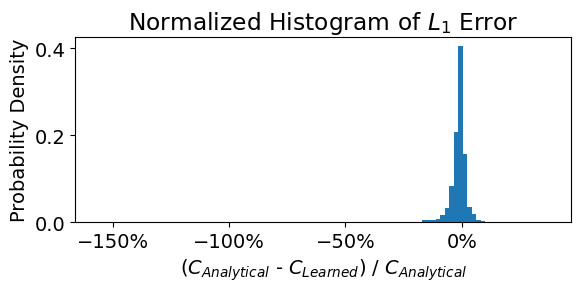

In [30]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(6.4, 2.4))
data = df['norm_delta'].values
ax.hist(data, bins=100, weights=np.ones_like(data)/len(data))
ax.set_xlabel('($C_{Analytical}$ - $C_{Learned}$) / $C_{Analytical}$')
ax.set_ylabel('Probability Density')
ax.set_title('Normalized Histogram of $L_1$ Error')
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
# save_fig(fig, 'learned_cost_model_l1_error.pdf')

In [31]:
cutoff = 0.05
data = df[(df.norm_delta < cutoff) & (df.norm_delta > -cutoff)]
print(f'Percentange within {cutoff:.0%} delta: {len(data) / len(df):.3%}')

Percentange within 5% delta: 89.200%


In [32]:
data = df[(df.norm_delta < 0.05) & (df.norm_delta > -0.05)]
data.sort_values(by='norm_delta')

,z0,z1,q,w,B,s,E,H,N,h,T,Q,cost_lcm,cost_acm,delta,norm_delta
4551,0.014,0.515,0.003,0.468,16.0,6.864244e-09,2048,7.271607,618985039,6.707,3,1,1.267765,1.207640,-0.060124,-0.049787
3197,0.722,0.051,0.131,0.096,64.0,1.898581e-08,2048,17.015998,993772690,4.065,17,6,2.420671,2.305907,-0.114764,-0.049769
2852,0.750,0.019,0.220,0.011,32.0,9.985939e-08,1024,15.908145,496735133,11.301,3,1,1.529133,1.456701,-0.072432,-0.049723
2802,0.037,0.662,0.159,0.142,32.0,1.893172e-08,4096,15.536033,304592228,1.551,12,1,1.293965,1.232907,-0.061058,-0.049524
255,0.236,0.197,0.073,0.494,32.0,2.727251e-08,2048,15.734143,348156418,14.737,24,7,1.685736,1.606231,-0.079505,-0.049498
4845,0.034,0.100,0.696,0.170,32.0,1.229628e-08,2048,19.333083,457329676,6.418,2,1,5.673066,5.405714,-0.267352,-0.049457
2316,0.216,0.551,0.098,0.135,32.0,5.189566e-08,1024,16.221201,120948822,6.630,11,6,1.989228,1.895509,-0.093719,-0.049443
4347,0.188,0.355,0.002,0.455,4.0,7.010380e-08,8192,18.665429,630453958,1.953,17,11,3.098359,2.952445,-0.145914,-0.049422
3173,0.001,0.490,0.303,0.206,32.0,9.487481e-08,1024,13.338545,965465858,4.846,7,2,3.110456,2.964012,-0.146444,-0.049407
3143,0.061,0.249,0.016,0.674,4.0,5.551387e-08,8192,15.578511,949518938,10.657,10,5,2.355438,2.244577,-0.110862,-0.049391


In [33]:
data = df[(df.norm_delta > 0.05) | (df.norm_delta < -0.05)]
data.sort_values(by='norm_delta')

,z0,z1,q,w,B,s,E,H,N,h,T,Q,cost_lcm,cost_acm,delta,norm_delta
1828,0.411,0.017,0.001,0.571,32.0,3.782614e-08,1024,13.774623,235345153,13.410,29,25,0.474470,0.184925,-0.289545,-1.565747
485,0.010,0.160,0.002,0.828,32.0,3.393322e-08,2048,18.766760,963572176,12.887,28,26,0.601362,0.351554,-0.249808,-0.710583
1881,0.665,0.131,0.007,0.197,128.0,2.028675e-08,1024,19.466608,104689757,14.515,8,5,0.345413,0.235593,-0.109820,-0.466140
2072,0.822,0.062,0.008,0.108,64.0,4.267171e-08,1024,13.670912,481510341,6.295,2,1,0.440454,0.308751,-0.131703,-0.426568
3745,0.181,0.254,0.002,0.563,32.0,9.815172e-08,1024,9.122149,153532633,6.216,27,25,1.165901,0.858250,-0.307651,-0.358462
2043,0.746,0.146,0.002,0.106,128.0,8.271510e-08,1024,10.430765,163946701,6.339,18,14,1.192007,0.881759,-0.310248,-0.351852
1457,0.874,0.107,0.006,0.013,32.0,8.589211e-08,2048,11.558145,716703416,8.871,7,4,0.387275,0.287287,-0.099987,-0.348038
3374,0.002,0.241,0.006,0.751,128.0,7.795814e-08,1024,18.582545,993218625,8.081,28,19,0.635358,0.474696,-0.160663,-0.338454
1293,0.418,0.071,0.002,0.509,32.0,9.775736e-08,2048,18.679546,765460762,6.656,19,16,0.739969,0.556437,-0.183531,-0.329833
1752,0.023,0.256,0.005,0.716,32.0,9.674728e-08,1024,19.225993,374897320,18.140,26,13,0.709614,0.536195,-0.173418,-0.323424


In [34]:
def plot_workload_trend(df, trend='stune_T'):
    fig = plt.figure()
    ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
    fig.add_axes(ax)
    ax.set_xlim3d(0, 1), ax.set_ylim3d(1, 0), ax.set_zlim3d(0, 1)
    ax.set_xticks([0, 0.5, 1]), ax.set_yticks([0, 0.5, 1]), ax.set_zticks([0, 0.5, 1])
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)

    ax.set_xlabel('Point-Reads\n($z_0$ + $z_1$)', labelpad=15)
    ax.set_ylabel('Range-Reads (q)', labelpad=10)
    ax.set_zlabel('Writes (w)', labelpad=10)

    sc = ax.scatter(df['z0'] + df['z1'], df['q'], df['w'], c=df[trend], cmap='viridis')
    cbar = plt.colorbar(sc)
    cbar.set_label(trend)
    
    return fig, ax, sc, cbar

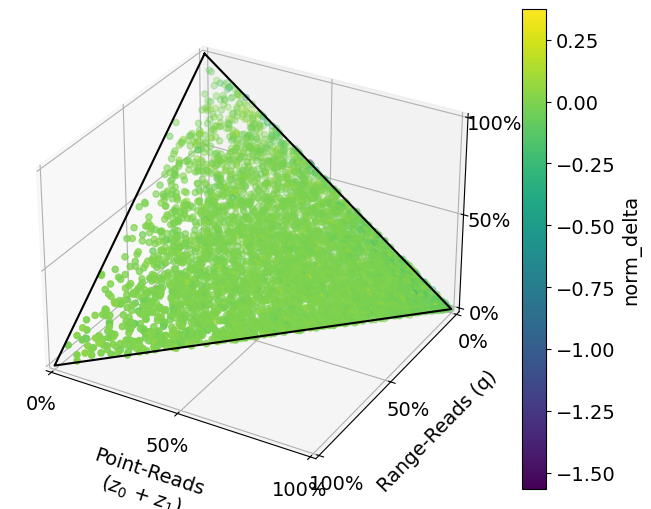

In [35]:
fig, ax, sc, cbar = plot_workload_trend(df, 'norm_delta')

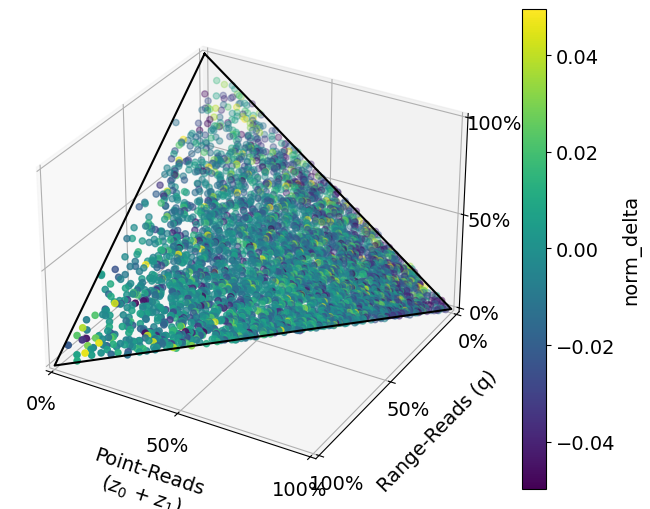

In [36]:
fig, ax, sc, cbar = plot_workload_trend(df[(df.norm_delta < 0.05) & (df.norm_delta > -0.05)], 'norm_delta')

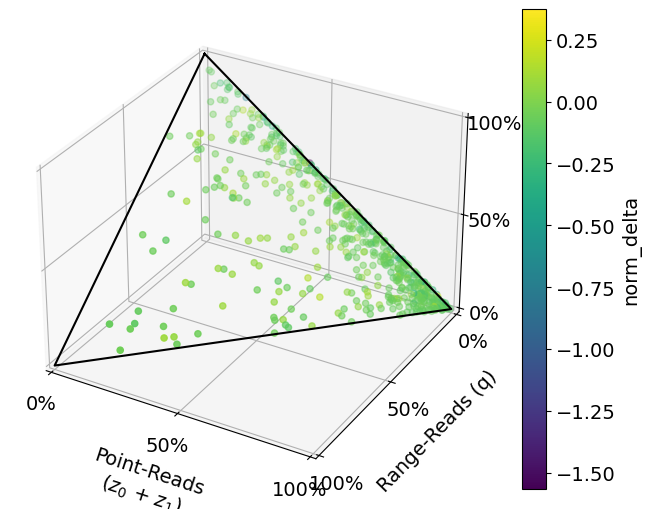

In [37]:
fig, ax, sc, cbar = plot_workload_trend(df[(df.norm_delta > 0.05) | (df.norm_delta < -0.05)], 'norm_delta')

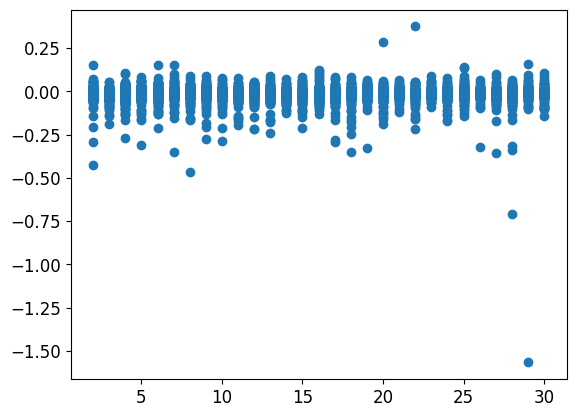

In [38]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots()
ax.scatter(df['T'], df.norm_delta)
None

In [39]:
acm = eval_util.cf.calc_cost(design, system, z0, z1, q, w)
lcm = eval_util.eval_lcm(design, system, z0, z1, q, w)
acm, lcm, (acm - lcm) / acm

(2.5178780667949616, 2.548788070678711, -0.0122762115812443)

In [40]:
[eval_util.cf.Z0(design, system), eval_util.cf.Z1(design, system), eval_util.cf.W(design, system), eval_util.cf.Q(design, system)] 

[0.1541833953984917,
 1.0681953157847528,
 0.04501309955639032,
 11.928466388399947]